In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
last_season = LeagueDashPlayerPtShot(per_mode_simple='PerGame', season='2020-21', general_range_nullable='Pullups').get_data_frames()[0]


In [5]:
cur_season = LeagueDashPlayerPtShot(per_mode_simple='PerGame', season='2021-22', general_range_nullable='Pullups').get_data_frames()[0]

In [9]:
merged_df = pd.merge(left=last_season, right=cur_season, on='PLAYER_ID', suffixes=('_LAST', '_CUR'))

In [20]:
merged_df = merged_df.loc[((merged_df.FGA_LAST > 6) | (merged_df.FGA_CUR > 6)) & (merged_df.GP_LAST > 10) & (merged_df.GP_CUR > 3)]

In [21]:
shooters = merged_df.loc[(merged_df.FG3A_LAST >= 4) | (merged_df.FG3A_CUR >= 4)]

In [22]:
plt.style.use('fivethirtyeight')

In [31]:
shooters.FG3_PCT_LAST = shooters.FG3_PCT_LAST * 100
shooters.FG3_PCT_CUR = shooters.FG3_PCT_CUR * 100

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [47]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path, zoom=1.0):
    #print(path)
    return OffsetImage(plt.imread(path), zoom=zoom)


In [47]:
x_plot = np.arange(30, 43, 1)
y_plot = np.arange(30, 43, 1)

In [83]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mtick


In [87]:
import matplotlib.ticker as mtick


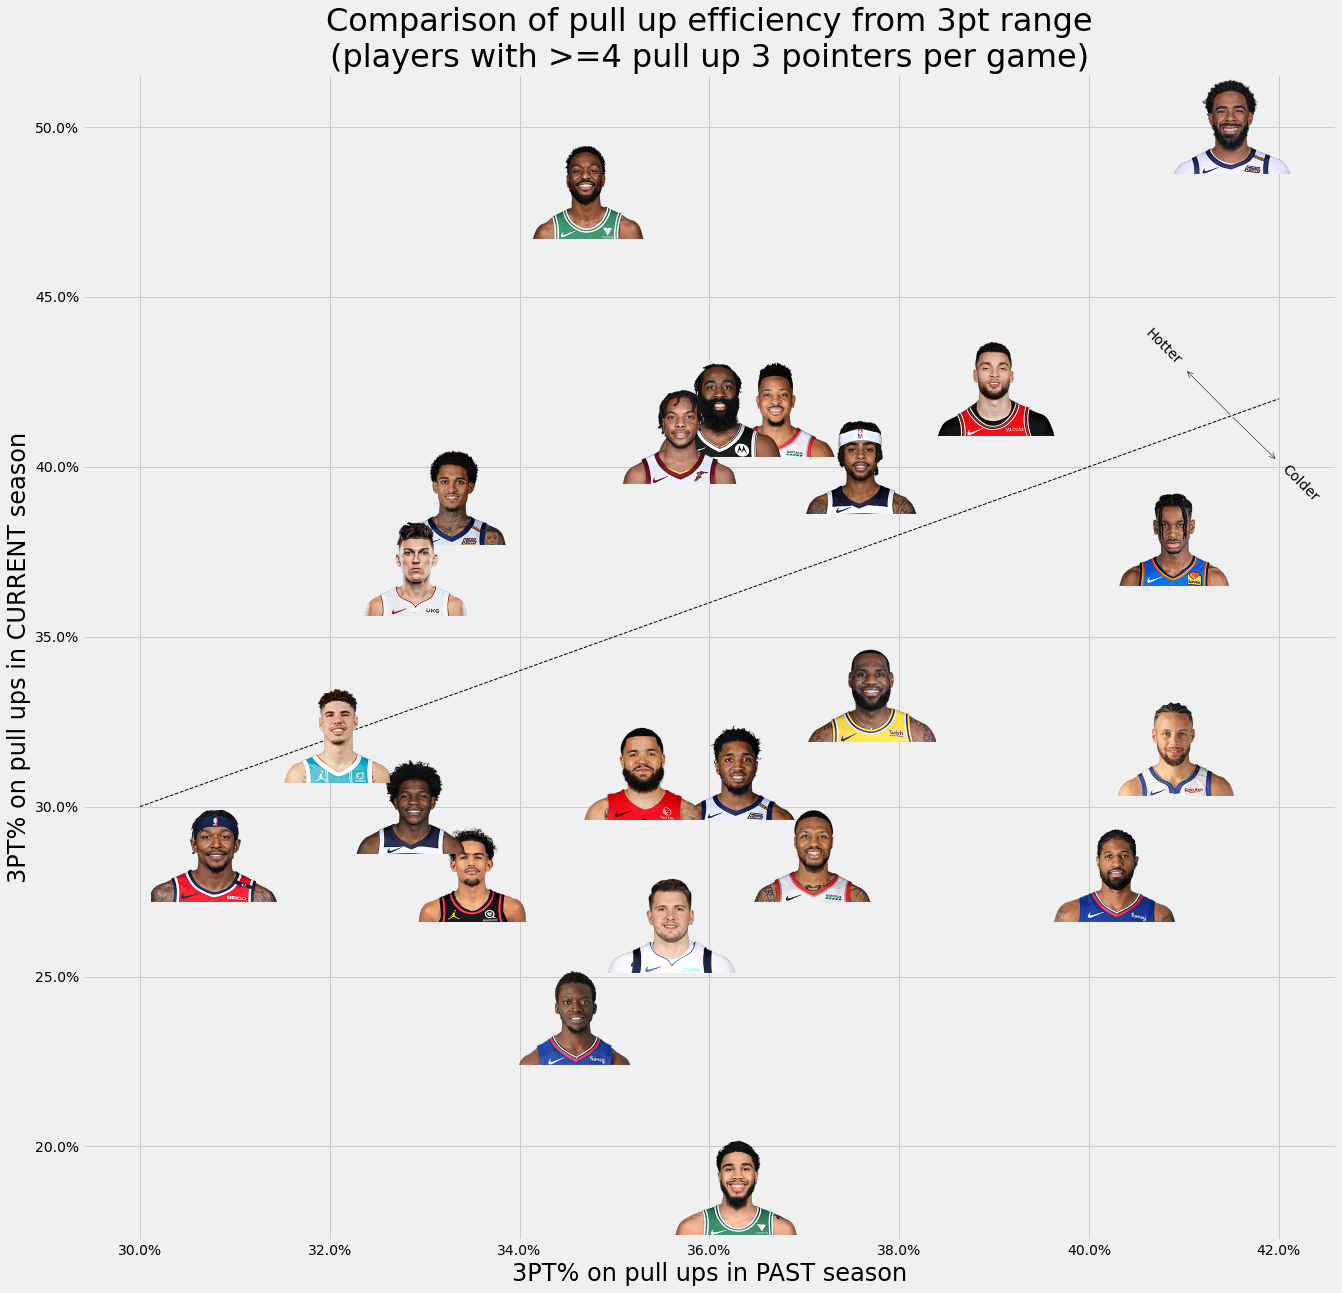

In [88]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(x=shooters.FG3_PCT_LAST, y=shooters.FG3_PCT_CUR, s=100)

paths = []
for i in range(len(shooters)):
    item = shooters.iloc[i]
    paths.append(f'player_imgs/{item.PLAYER_ID}.png')

x = shooters.FG3_PCT_LAST.tolist()
y = shooters.FG3_PCT_CUR.tolist()

for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path, zoom=0.5), (x0, y0), frameon=False)
    ax.add_artist(ab)
    
ax.set_xlabel("3PT% on pull ups in PAST season", size=24)
ax.set_ylabel("3PT% on pull ups in CURRENT season", size=24)
ax.set_title("Comparison of pull up efficiency from 3pt range\n(players with >=4 pull up 3 pointers per game)", size=32)

#ax.set_xticklabels([f"{item}%" for item in range(30, 44, 2)])
#ax.set_yticklabels([f"{item}%" for item in range(15, 55, 5)])
ax.plot(x_plot, y_plot, color='black', ls='--', lw=1)

#ax.text(x=41.5, y=40, s='Colder', rotation=-45)
#ax.text(x=41.5, y=42.5, s='Hotter', rotation=45)
ax.annotate('Colder', (41.5, 41.5), xytext=(42, 39), rotation=-45, arrowprops={'arrowstyle': '<-', 'color': 'black'})
ax.annotate('Hotter', (41.5, 41.5), xytext=(41, 43), rotation=-45, arrowprops={'arrowstyle': '<-', 'color': 'black'}, ha='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())


### Game by game player stats

In [81]:
last_season_top = LeagueDashPlayerStats(season='2020-21', per_mode_detailed='PerGame').get_data_frames()[0]

In [92]:
last_season_top = last_season_top.loc[last_season_top.GP > 20]

In [95]:
last_season_top = last_season_top.sort_values(by='PTS', ascending=False).iloc[:60]

In [108]:
target_players = last_season_top.PLAYER_ID.tolist()

In [122]:
from datetime import date, timedelta


In [123]:

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2020, 12, 20)
end_date = date(2021, 5, 17)
#10%2F28%2F2021
for single_date in daterange(start_date, end_date):
    print(single_date.strftime("%m-%d-%Y"))

12-20-2020
12-21-2020
12-22-2020
12-23-2020
12-24-2020
12-25-2020
12-26-2020
12-27-2020
12-28-2020
12-29-2020
12-30-2020
12-31-2020
01-01-2021
01-02-2021
01-03-2021
01-04-2021
01-05-2021
01-06-2021
01-07-2021
01-08-2021
01-09-2021
01-10-2021
01-11-2021
01-12-2021
01-13-2021
01-14-2021
01-15-2021
01-16-2021
01-17-2021
01-18-2021
01-19-2021
01-20-2021
01-21-2021
01-22-2021
01-23-2021
01-24-2021
01-25-2021
01-26-2021
01-27-2021
01-28-2021
01-29-2021
01-30-2021
01-31-2021
02-01-2021
02-02-2021
02-03-2021
02-04-2021
02-05-2021
02-06-2021
02-07-2021
02-08-2021
02-09-2021
02-10-2021
02-11-2021
02-12-2021
02-13-2021
02-14-2021
02-15-2021
02-16-2021
02-17-2021
02-18-2021
02-19-2021
02-20-2021
02-21-2021
02-22-2021
02-23-2021
02-24-2021
02-25-2021
02-26-2021
02-27-2021
02-28-2021
03-01-2021
03-02-2021
03-03-2021
03-04-2021
03-05-2021
03-06-2021
03-07-2021
03-08-2021
03-09-2021
03-10-2021
03-11-2021
03-12-2021
03-13-2021
03-14-2021
03-15-2021
03-16-2021
03-17-2021
03-18-2021
03-19-2021
03-20-2021

In [110]:
last_season_top.FG3M.sum() / last_season_top.FGA.sum()

0.4761997279968914

In [125]:


start_date = date(2020, 12, 24)
end_date = date(2021, 5, 17)

fg_pcts = []
fg3_pcts = []

for single_date in tqdm.tqdm(daterange(start_date, end_date)):
    target_date = single_date.strftime("%m-%d-%Y")
    stats = LeagueDashPlayerStats(season='2020-21', per_mode_detailed='PerGame', date_to_nullable=target_date).get_data_frames()[0]
    target_df = stats.loc[stats.PLAYER_ID.isin(target_players)]
    fg_pcts.append(stats.FGM.sum() / stats.FGA.sum())
    fg3_pcts.append(stats.FG3M.sum() / stats.FG3A.sum())
    time.sleep(0.3)



0it [00:00, ?it/s]

1it [00:00,  1.94it/s]

2it [00:01,  1.85it/s]

3it [00:01,  1.82it/s]

4it [00:02,  1.84it/s]

5it [00:02,  1.72it/s]

6it [00:03,  1.76it/s]

7it [00:04,  1.50it/s]

8it [00:05,  1.11it/s]

9it [00:06,  1.22it/s]

10it [00:07,  1.03it/s]

11it [00:08,  1.06s/it]

12it [00:09,  1.09it/s]

13it [00:10,  1.00s/it]

14it [00:11,  1.11it/s]

15it [00:12,  1.05it/s]

16it [00:13,  1.17it/s]

17it [00:13,  1.23it/s]

18it [00:14,  1.32it/s]

19it [00:15,  1.42it/s]

20it [00:15,  1.50it/s]

21it [00:16,  1.57it/s]

22it [00:16,  1.61it/s]

23it [00:17,  1.62it/s]

24it [00:17,  1.63it/s]

25it [00:18,  1.51it/s]

26it [00:19,  1.54it/s]

27it [00:20,  1.55it/s]

28it [00:20,  1.61it/s]

29it [00:21,  1.62it/s]

30it [00:22,  1.47it/s]

31it [00:22,  1.50it/s]

32it [00:23,  1.51it/s]

33it [00:23,  1.59it/s]

34it [00:24,  1.61it/s]

35it [00:25,  1.64it/s]

36it [00:25,  1.66it/s]

37it [00:26,  1.65it/s]

38it [00:26,  1.66it/s]

39it [00:28,  1.11it/s]

40it [00:29,

## Box score analyzer

In [4]:
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs

In [7]:
mpj_id = find_players_by_full_name("Michael Porter Jr.")[0]['id']

In [8]:
mpj_id

1629008

In [10]:
first_season = PlayerGameLogs(season_nullable='2019-20', player_id_nullable=mpj_id).get_data_frames()[0]

In [11]:
second_season = PlayerGameLogs(season_nullable='2020-21', player_id_nullable=mpj_id).get_data_frames()[0]

In [14]:
first_season = first_season.reset_index()
second_season = second_season.reset_index()

In [18]:
first_season.loc[first_season.FG3_PCT < 0.34]

,index,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,VIDEO_AVAILABLE_FLAG
0,0,2019-20,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0021901307,2020-08-12T00:00:00,...,4,1,40,10,18,54,16,10,1,1
2,2,2019-20,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0021901281,2020-08-08T00:00:00,...,4,48,48,2,5,4,4,1,1,1
6,6,2019-20,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0021901239,2020-08-01T00:00:00,...,4,1,55,13,18,53,24,10,1,1
7,7,2019-20,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0021900973,2020-03-11T00:00:00,...,23,38,11,13,50,23,46,10,1,1
8,8,2019-20,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0021900958,2020-03-09T00:00:00,...,23,1,11,32,50,20,53,10,1,1
9,9,2019-20,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0021900942,2020-03-07T00:00:00,...,23,1,11,13,26,32,29,10,1,1
11,11,2019-20,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0021900898,2020-03-01T00:00:00,...,23,38,1,7,18,28,14,10,1,1
13,13,2019-20,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0021900860,2020-02-25T00:00:00,...,23,1,11,13,15,13,21,10,1,1
14,14,2019-20,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0021900844,2020-02-23T00:00:00,...,23,1,40,32,43,49,41,10,1,1
15,15,2019-20,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0021900831,2020-02-21T00:00:00,...,23,1,1,32,35,52,43,10,1,1


In [20]:
second_season.loc[second_season.FG3_PCT < 0.3]

,index,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,VIDEO_AVAILABLE_FLAG
1,1,2020-21,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0022001054,2021-05-14T00:00:00,...,37,43,8,15,53,20,52,16,1,1
6,6,2020-21,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0022000982,2021-05-03T00:00:00,...,37,1,25,15,31,45,48,16,1,1
13,13,2020-21,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0022000890,2021-04-21T00:00:00,...,37,1,39,50,38,41,50,16,1,1
17,17,2020-21,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0022000821,2021-04-12T00:00:00,...,37,58,8,24,16,58,23,16,1,1
18,18,2020-21,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0022000806,2021-04-11T00:00:00,...,14,43,8,9,21,26,14,1,1,1
19,19,2020-21,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0022000797,2021-04-09T00:00:00,...,14,1,25,3,21,35,15,1,1,1
30,30,2020-21,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0022000637,2021-03-19T00:00:00,...,37,43,1,5,31,14,34,16,1,1
32,32,2020-21,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0022000606,2021-03-15T00:00:00,...,14,1,25,24,27,13,26,16,1,1
43,43,2020-21,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0022000437,2021-02-17T00:00:00,...,14,1,58,24,45,44,43,16,1,1
44,44,2020-21,1629008,Michael Porter Jr.,Michael,1610612743,DEN,Denver Nuggets,0022000427,2021-02-16T00:00:00,...,14,1,25,50,61,41,58,16,1,1


In [22]:
bad_streak = second_season.loc[(second_season.index >= 43) & (second_season.index <= 46)]

In [25]:
for made, att in zip(bad_streak.FG3M.tolist(), bad_streak.FG3A.tolist()):
    print(f"{made}/{att}")

2/7
0/5
1/7
1/6


In [26]:
interesting_streak = second_season.loc[(second_season.index >= 33) & (second_season.index <= 42)]

In [28]:
for made, att in zip(interesting_streak.FG3M.tolist(), interesting_streak.FG3A.tolist()):
    print(f"{made}/{att}, {round(made / att * 100, 2)}")

4/5, 80.0
2/4, 50.0
5/9, 55.56
3/6, 50.0
2/4, 50.0
5/8, 62.5
3/7, 42.86
2/4, 50.0
1/3, 33.33
3/6, 50.0


In [31]:
sum(interesting_streak.FG3M.tolist()) / sum(interesting_streak.FG3A.tolist())

0.5357142857142857

In [32]:
sum(interesting_streak.FG3M.tolist()),  sum(interesting_streak.FG3A.tolist())

(30, 56)

In [38]:
interesting_streak = second_season.loc[(second_season.index >= 51)]

In [39]:
for made, att in zip(interesting_streak.FG3M.tolist(), interesting_streak.FG3A.tolist()):
    print(f"{made}/{att}, {round(made / att * 100, 2)}")

1/1, 100.0
2/2, 100.0
3/7, 42.86
6/10, 60.0
3/4, 75.0
1/4, 25.0
4/7, 57.14
2/6, 33.33
2/6, 33.33
3/7, 42.86


### Analyze wide open shots

In [40]:
last_year = LeagueDashPlayerPtShot(per_mode_simple='PerGame', season='2020-21', close_def_dist_range_nullable='6+ Feet - Wide Open').get_data_frames()[0]

In [42]:
cur_year = LeagueDashPlayerPtShot(per_mode_simple='PerGame', season='2021-22', close_def_dist_range_nullable='6+ Feet - Wide Open').get_data_frames()[0]

In [43]:
merged_wide_open = pd.merge(left=last_year, right=cur_year, on='PLAYER_ID', suffixes=('_LAST', '_CUR'))

In [69]:
shooters_only = merged_wide_open.loc[(merged_wide_open.FG3A_CUR > 3) | ((merged_wide_open.FG3A_LAST > 3))]
shooters_only.FG3_PCT_LAST = shooters_only.FG3_PCT_LAST * 100
shooters_only.FG3_PCT_CUR = shooters_only.FG3_PCT_CUR * 100

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [70]:
plt.style.use('fivethirtyeight')

In [71]:
x_plot = np.arange(31, 54, 1)
y_plot = np.arange(31, 54, 1)

from matplotlib.ticker import FormatStrFormatter


import matplotlib.ticker as mtick


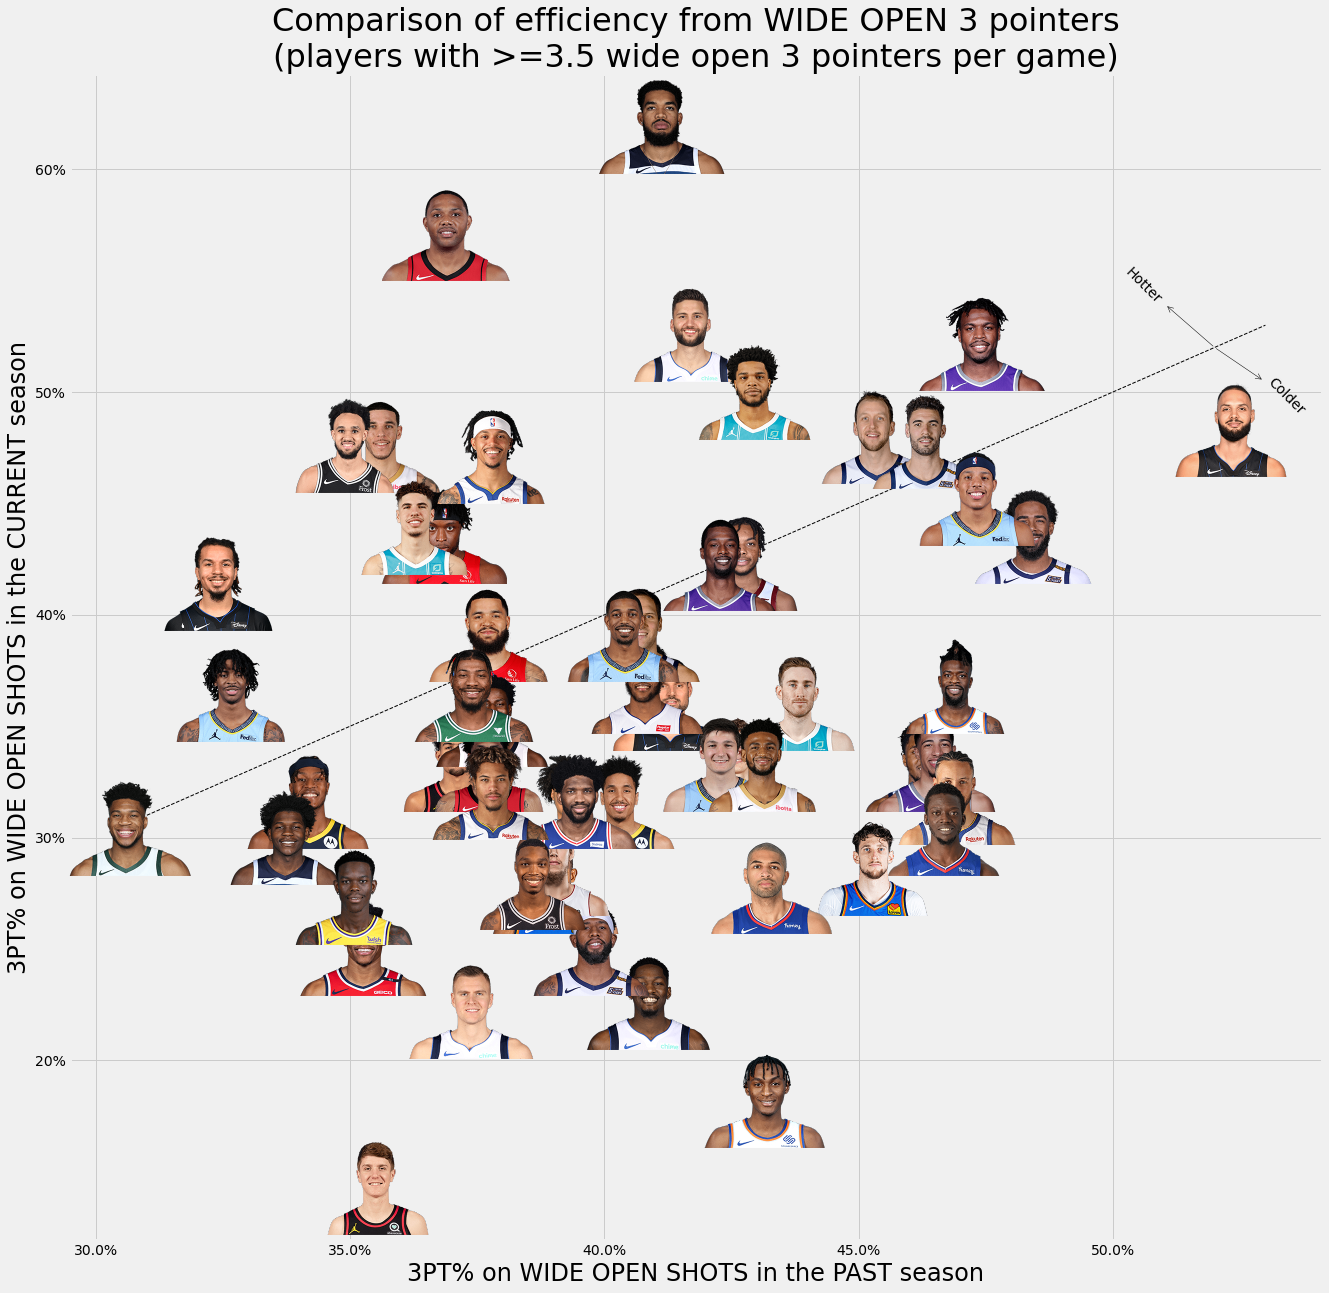

In [72]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(x=shooters_only.FG3_PCT_LAST, y=shooters_only.FG3_PCT_CUR, s=100)

paths = []
for i in range(len(shooters_only)):
    item = shooters_only.iloc[i]
    paths.append(f'player_imgs/{item.PLAYER_ID}.png')

x = shooters_only.FG3_PCT_LAST.tolist()
y = shooters_only.FG3_PCT_CUR.tolist()

for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path, zoom=0.5), (x0, y0), frameon=False)
    ax.add_artist(ab)
    
    
ax.set_xlabel("3PT% on WIDE OPEN SHOTS in the PAST season", size=24)
ax.set_ylabel("3PT% on WIDE OPEN SHOTS in the CURRENT season", size=24)
ax.set_title("Comparison of efficiency from WIDE OPEN 3 pointers\n(players with >=3.5 wide open 3 pointers per game)", size=32)


ax.plot(x_plot, y_plot, color='black', ls='--', lw=1)

#ax.text(x=41.5, y=40, s='Colder', rotation=-45)
#ax.text(x=41.5, y=42.5, s='Hotter', rotation=45)
ax.annotate('Colder', (52, 52), xytext=(53, 49), rotation=-45, arrowprops={'arrowstyle': '<-', 'color': 'black'})
ax.annotate('Hotter', (52, 52), xytext=(51, 54), rotation=-45, arrowprops={'arrowstyle': '<-', 'color': 'black'}, ha='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())


In [73]:
len(shooters_only)

56

In [74]:
len(shooters_only.loc[shooters_only.FG3_PCT_CUR < shooters_only.FG3_PCT_LAST])

40